In [1]:

import numpy as np
import pandas as pd
import pickle
import networkx as nx 
import osmnx as ox 
import numpy as np 
import seaborn as sns 

In [2]:
#Load volume dataset
csv_pd=pd.read_excel(r"C:\Users\anton\Desktop\Master-Oppgave\Kode\New_Traffic\weekly_data\weekly_data_xl.xlsx")

# Load graph
with open(r"C:\Users\anton\Desktop\Master-Oppgave\Kode\New_Traffic\data\BaseGraph_E_NOR_wagrades.pickle", 'rb') as file:
    H = pickle.load(file)


C:\Users\anton\AppData\Local\Temp/ipykernel_32588/4231653125.py:6: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  H = pickle.load(file)


In [3]:
#Remove volume1 and volume2
csv_pd=csv_pd.drop("volume1", axis="columns")
csv_pd=csv_pd.drop("volume2", axis="columns")

In [4]:
csv_pd.head()

,id,name,lat,lon,volume,year,month
0,41379V1201935,MESNADALSARMEN,61.115044,10.456279,13023,2018,1
1,41379V1201935,MESNADALSARMEN,61.115044,10.456279,13998,2018,2
2,41379V1201935,MESNADALSARMEN,61.115044,10.456279,13878,2018,3
3,41379V1201935,MESNADALSARMEN,61.115044,10.456279,14288,2018,4
4,41379V1201935,MESNADALSARMEN,61.115044,10.456279,14669,2018,5


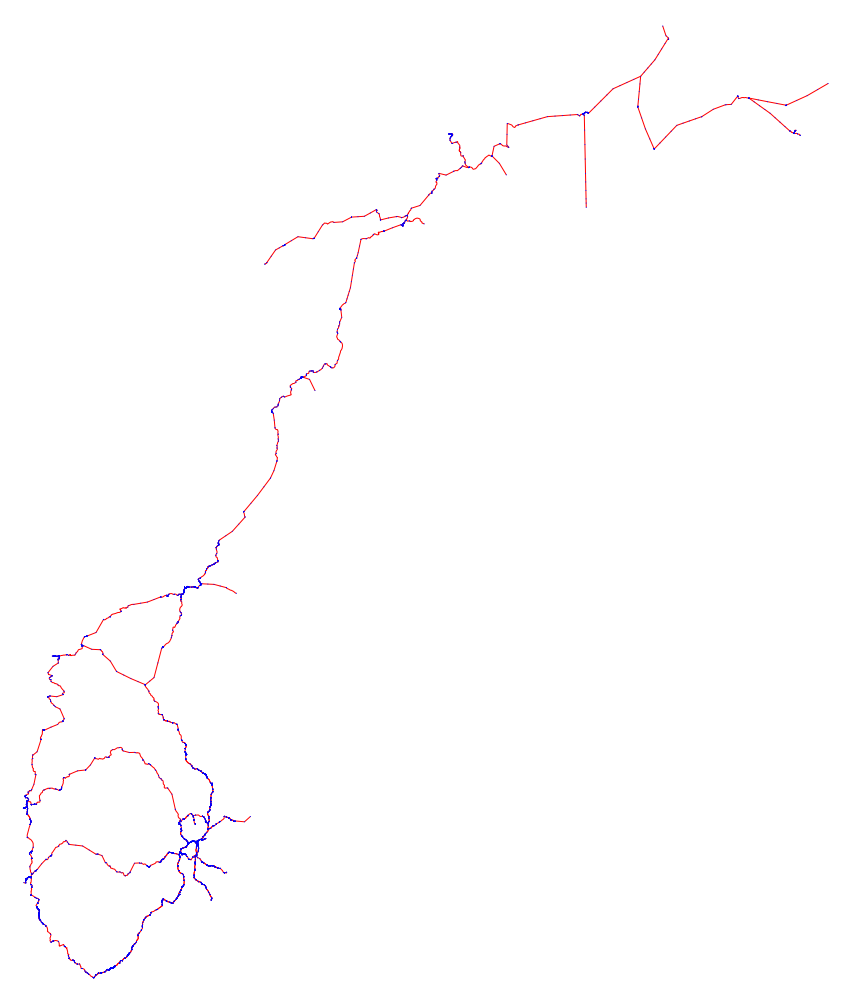

(<Figure size 1080x2160 with 1 Axes>, <AxesSubplot: >)

In [5]:
#Plot graph
ox.plot_graph(H, figsize = (15, 30), node_color="blue", edge_color = "red", bgcolor = "white", node_size=1, edge_linewidth = 1)

In [ ]:
print("Nodes:", list(H.nodes))
print("Edges:", list(H.edges))


In [ ]:
print("Adjacency List:")
for node in H.adj:
    print(node, H.adj[node])


In [3]:
# Retrieve absolute value of gradients

lengths = []
for i in H.edges:
    length = H.edges[i]['length']
    lengths.append(length)

grades = [abs(H.edges[i]['wa_grade']) for i in H.edges]  

In [4]:
#Create grades and elevations from H.nodes
grades = [H.edges[i]['wa_grade'] for i in H.edges]
#elevations = [H.nodes[i]['elevation'] if float('-inf') < H.nodes[i]['elevation'] < float('inf') else 0 for i in H.nodes]
elevations = [H.nodes[i]['elevation'] if np.all(np.logical_and(float('-inf') < H.nodes[i]['elevation'], H.nodes[i]['elevation'] < float('inf'))) else 0 for i in H.nodes]


In [13]:
list(H.nodes(data=True))[0:5]
#list(H.edges(data=True))[0:5]

[(0,
  {'x': 11.127465806112035,
   'y': 60.78620456025842,
   'osmid': 155191,
   'roadclass': 0,
   'isBridge': 0,
   'isTunnel': 0,
   'geometry': <POINT (11.127 60.786)>,
   'elevation': 143.16}),
 (1,
  {'x': 11.127184981853482,
   'y': 60.78642854398455,
   'osmid': 155201,
   'roadclass': 0,
   'isBridge': 0,
   'isTunnel': 0,
   'geometry': <POINT (11.127 60.786)>,
   'elevation': 142.7}),
 (2,
  {'x': 11.127534712389643,
   'y': 60.78633428345484,
   'osmid': 155273,
   'roadclass': 0,
   'isBridge': 0,
   'isTunnel': 0,
   'geometry': <POINT (11.128 60.786)>,
   'elevation': 142.705}),
 (3,
  {'x': 11.127399824588059,
   'y': 60.786415782679235,
   'osmid': 155289,
   'roadclass': 0,
   'isBridge': 0,
   'isTunnel': 0,
   'geometry': <POINT (11.127 60.786)>,
   'elevation': 142.543}),
 (4,
  {'x': 11.993829462815306,
   'y': 60.189188517538796,
   'osmid': 155971,
   'roadclass': 0,
   'isBridge': 0,
   'isTunnel': 0,
   'geometry': <POINT (11.994 60.189)>,
   'elevation': 15

In [16]:
H.nodes[v]['geometry'].coords[0]

(10.449995165715421, 61.11572265405716)

In [5]:
labels={n[1]:n[0] for n in enumerate(H.nodes)}

H=nx.relabel_nodes(H, labels)

*#Trying to add month attribute to H object*


In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import geopandas as gpd
import networkx as nx

# create road nodes array with latitude and longitude information
road_nodes = np.array([(node, data['geometry'].coords[0][0], data['geometry'].coords[0][1])
                      for node, data in H.nodes(data=True)])

# iterate over each row in the volume dataframe and assign volume to edges in the graph
for i, row in csv_pd.iterrows():
    # get the closest road node to the volume point
    point = row[['lon', 'lat']].values.reshape(1, -1)
    dist_matrix = cdist(point, road_nodes[:, 1:], metric='euclidean')
    min_index = np.argmin(dist_matrix)
    node_id = road_nodes[min_index, 0]
    
    # assign volume to each edge in the graph that contains the closest road node
    edges = H.edges(node_id, data=True)
    total_distance = sum([H[u][v]['length'] for (u, v) in [(e[0], e[1]) for e in edges]])
    for u, v, data in edges:
        edge_weight = data['length']
        month_volume = row['volume{}'.format(row['month'])]
        traffic_flow = month_volume * (edge_weight / total_distance)
        if 'traffic_flow' not in data:
            data['traffic_flow'] = traffic_flow
        else:
            data['traffic_flow'] += traffic_flow
        nx.set_edge_attributes(H, {(u,v): {'traffic_flow': data['traffic_flow']}})

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString

# create road nodes array with latitude and longitude information
road_nodes = np.array([(node, data['geometry'].coords[0][0], data['geometry'].coords[0][1])
                      for node, data in H.nodes(data=True)])

# convert the traffic registration points to a GeoDataFrame
traffic_points = gpd.GeoDataFrame(csv_pd, geometry=gpd.points_from_xy(csv_pd['lon'], csv_pd['lat']))

# define a function to find the nearest edge to a point
def nearest_edge(point, road_nodes):
    point = (point.x, point.y)
    dist_matrix = cdist([point], road_nodes[:, 1:], metric='euclidean')
    min_index = np.argmin(dist_matrix)
    node_id = road_nodes[min_index, 0]
    edges = H.edges(node_id, data=True)
    edge_distances = [LineString([H.nodes[u]['geometry'].coords[0], H.nodes[v]['geometry'].coords[0]]).distance(Point(point)) for u, v, _ in edges]
    nearest_edge = list(edges)[np.argmin(edge_distances)]
    return nearest_edge

# find the nearest edge to each traffic point
traffic_points['nearest_edge'] = traffic_points.geometry.apply(lambda x: nearest_edge(x, road_nodes))



# iterate over each row in the volume dataframe and assign volume to edges in the graph
for i, row in traffic_points.iterrows():
    # assign volume to each edge in the graph that contains the closest road node
    u, v, data = row['nearest_edge']
    month_volume = row['volume{}'.format(row['month'])]
    if 'volume' not in data:
        data['volume'] = month_volume
    else:
        data['volume'] += month_volume
    


In [7]:
traffic_points
for i in traffic_points["volume"]:
    if i == "13511":
        print(i, "True")


In [ ]:
traffic_points['nearest_edge']

In [ ]:
traffic_points['nearest_edge'][0]

<AxesSubplot: >

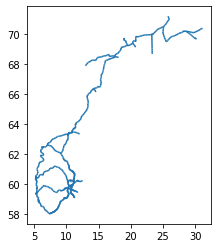

In [37]:
edge_gdf.plot()

In [ ]:
from shapely.geometry import Point, LineString, MultiPoint, MultiLineString
import numpy as np
import pandas as pd
import pickle
import numpy as np
import networkx as nx 
import osmnx as ox 
import numpy as np 
import seaborn as sns 
import geopandas as gpd

# Assuming your LineStrings are stored in a GeoDataFrame called 'line_strings_df'
# and your geometry points are stored in a GeoDataFrame called 'points_df'

#Load volume dataset
csv_pd=pd.read_excel(r"C:\Users\anton\Desktop\Master-Oppgave\Kode\New_Traffic\weekly_data\weekly_data_xl.xlsx")

# Create a new column with Shapely Point geometries
csv_pd['geometry'] = csv_pd.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Load graph
with open(r"C:\Users\anton\Desktop\Master-Oppgave\Kode\New_Traffic\data\BaseGraph_E_NOR_wagrades.pickle", 'rb') as file:
    H = pickle.load(file)

# convert the networkx graph to a GeoDataFrame
gdf = ox.graph_to_gdfs(H, nodes=False, edges=True, node_geometry=False)

# Convert the GeoDataFrame of geometry points to a MultiPoint object
points = MultiPoint(csv_pd['geometry'])

gdf['geometry'] = gdf['geometry'].apply(lambda x: x if type(x) == LineString or type(x) == MultiLineString else LineString(x))


# Compute the nearest points between each LineString and the MultiPoint
nearest_points = gdf['geometry'].apply(lambda x: points.distance(x).min())


# Get the index of the nearest point for each LineString
nearest_point_index = np.argmin(nearest_points.values)

# Get the actual nearest point from the MultiPoint
nearest_point = points[nearest_point_index]

# Print the nearest point
print("Nearest point:", nearest_point)

In [18]:
print(gdf["geometry"])

u        v        key
155191   155273   0      LINESTRING (11.12747 60.78620, 11.12753 60.78633)
         351348   0      LINESTRING (11.12747 60.78620, 11.12754 60.786...
         155201   0      LINESTRING (11.12718 60.78643, 11.12699 60.786...
155201   155289   0      LINESTRING (11.12718 60.78643, 11.12740 60.78642)
         351618   0      LINESTRING (11.12527 60.78968, 11.12538 60.789...
                                               ...                        
1854885  1854918  0      LINESTRING (23.30886 68.89834, 23.31478 68.78165)
         1854904  0      LINESTRING (23.30293 69.01502, 23.30886 68.89834)
1854888  1854919  0      LINESTRING (15.79530 67.72583, 15.82742 67.81167)
         1854905  0      LINESTRING (15.76318 67.63998, 15.79530 67.72583)
1854918  1854920  0      LINESTRING (23.31478 68.78165, 23.31774 68.72331)
Name: geometry, Length: 9807, dtype: geometry


In [20]:
not_line_strings = gdf.loc[gdf['geometry'].apply(lambda x: type(x) != MultiLineString)]
print(not_line_strings)


                                                             id  oneway  \
u       v       key                                                       
155191  155273  0                                        138086   False   
        351348  0             [138014, 2168667, 362740, 363590]   False   
        155201  0      [138118, 138126, 138134, 138142, 138150]   False   
155201  155289  0                                        138110   False   
        351618  0    [363598, 362732, 2168670, 2168673, 138022]   False   
...                                                         ...     ...   
1854885 1854918 0                                          None   False   
        1854904 0                                          None   False   
1854888 1854919 0                                          None   False   
        1854905 0                                          None   False   
1854918 1854920 0                                          None   False   

                        

In [ ]:
# Convert MultiPoint object to GeoDataFrame
points_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(points))

points_gdf = points_gdf.set_crs(gdf.crs)

# Perform a spatial join between points and line segments to get the nearest line segment for each point
joined_gdf = gpd.sjoin(gdf, points_gdf, op='nearest')

# Group the joined GeoDataFrame by the point index and get the nearest line segment for each point
nearest_segments = joined_gdf.groupby('index_right')['geometry'].agg(lambda x: x.distance(points[x.name]).idxmin())


In [31]:
print(nearest_segments)
print(len(nearest_segments))


GeoSeries([], Name: geometry, dtype: geometry)
0


In [ ]:
from shapely.ops import nearest_points

# create a list of LineString objects from the GeoDataFrame
line_strings = list(gdf['geometry'])

# create a list of Point objects from the point GeoDataFrame
points = list(points_gdf['geometry'])

# create an empty list to store the nearest segment for each point
nearest_segments = []

# loop through each point and find the nearest line segment
for point in points:
    # initialize the minimum distance to a very large number
    min_distance = float('inf')
    
    # loop through each line segment and find the nearest point
    for line_string in line_strings:
        nearest_point = nearest_points(point, line_string)[0]
        
        # calculate the Euclidean distance between the point and the nearest point on the line segment
        distance = point.distance(nearest_point)
        
        # update the minimum distance if necessary
        if distance < min_distance:
            min_distance = distance
            nearest_segment = line_string
    
    # add the nearest segment to the list
    nearest_segments.append(nearest_segment)

# convert the list of LineString objects to a GeoDataFrame
nearest_segments_gdf = gpd.GeoDataFrame(geometry=nearest_segments, crs=gdf.crs)


In [35]:
print(nearest_segments_gdf)

                                            geometry
0  LINESTRING (11.12747 60.78620, 11.12753 60.78633)


In [ ]:
from shapely.ops import nearest_points
from geopandas.tools import sjoin

# Create a copy of the gdf GeoDataFrame and drop all columns except "geometry"
gdf_copy = gdf[["geometry"]].copy()

# Assign unique IDs to each row in the gdf_copy GeoDataFrame
gdf_copy["id"] = range(len(gdf_copy))

# Find the nearest linestring segment for each point in the csv_pd dataframe
nearest_segments = []
for point in csv_pd["geometry"]:
    nearest_line = nearest_points(point, gdf["geometry"])[1]
    nearest_segment = gdf[gdf["geometry"]==nearest_line]
    nearest_segments.append(nearest_segment)


In [45]:
csv_pd=csv_pd.rename(columns={"geometry": "geometry1"})


In [49]:


# Convert the nearest_segments list to a GeoDataFrame
nearest_segments_gdf = gpd.GeoDataFrame(pd.concat(nearest_segments), crs=gdf.crs).rename(columns={'geometry':'nearest_geometry'})

# create a list of Point geometries from the latitudes and longitudes in csv_pd
geometry = [Point(xy) for xy in zip(csv_pd["lon"], csv_pd["lat"])]

# create a GeoDataFrame with the point geometries and the original csv_pd data
csv_pd = gpd.GeoDataFrame(csv_pd, geometry=geometry)

# Combine the csv_pd and nearest_segments data into a single GeoDataFrame
nearest_segments_gdf = pd.concat([csv_pd, nearest_segments_gdf], axis=1)

# Perform a spatial join to get additional attributes from the original gdf GeoDataFrame
nearest_segments_gdf = sjoin(nearest_segments_gdf, gdf_copy, op="nearest")

# Drop the "index_right" and "id" columns from the final output GeoDataFrame
nearest_segments_gdf = nearest_segments_gdf.drop(["index_right", "id"], axis=1)


c:\Users\anton\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\anton\AppData\Local\Temp/ipykernel_23112/2572599642.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  nearest_segments_gdf = sjoin(nearest_segments_gdf, gdf_copy, op="nearest")


ValueError: Got `predicate` = `nearest`, `predicate` must be one of {'overlaps', 'crosses', 'covered_by', 'contains_properly', 'within', None, 'intersects', 'contains', 'covers', 'touches'}